In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Dense, LSTM
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [19]:
#load the IMDB dataset
movie_reviews = pd.read_csv("data/IMDB Dataset.csv")

movie_reviews.shape

(50000, 2)

In [20]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [21]:
# First step : Data Preprocessing

In [31]:


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [32]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [33]:
# let's apply the preprocessing function to our dataset
X= []
texts = list(movie_reviews['review'])
for text in texts:
    X.append(preprocess_text(text))
    
# our texts after preprocessing and cleaning


In [34]:
#Now, we need to convert our labels into digits. "positive" with digit 1 and "negative" with digit 0 
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [35]:
#Next, we need to divide our dataset into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
# Second step: Preparing the Embedding Layer

In [37]:
# 1 : we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [38]:
# 2 : script finds the vocabulary size and then perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#after padding X_train and X_test will contain 40000 list of 100 elements
print(X_train.shape)
print(X_test.shape)

(40000, 100)
(10000, 100)


In [39]:
# 3: create our feature matrix using  pre-trained word vectors  "Glove"
embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
# let’s have a quick look how many of the embedding vectors are nonzero 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("The percentage of vocabulary covered by Glove is ",nonzero_elements / vocab_size)

The percentage of vocabulary covered by Glove is  0.7555080121451803


In [42]:
#Third step :  building our first model Recurrent Neural Network (LSTM)

In [43]:
# Lstm Model 
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [44]:
#Fourth step : fitting and evaluation

In [45]:
#launch fitting and evaluation
history = model.fit(X_train, y_train, batch_size=128,epochs=5, verbose=1, validation_split=0.2)
print("\n")
print("****Launch Evaluation****")
print("\n")
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("\n")
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing loss: {:.4f}".format(loss))



Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 102s 3ms/step - loss: 0.5559 - acc: 0.7097 - val_loss: 0.4516 - val_acc: 0.7921
Epoch 2/5
32000/32000 [==============================] - 107s 3ms/step - loss: 0.4519 - acc: 0.7895 - val_loss: 0.4136 - val_acc: 0.8154
Epoch 3/5
32000/32000 [==============================] - 111s 3ms/step - loss: 0.3940 - acc: 0.8205 - val_loss: 0.3735 - val_acc: 0.8335
Epoch 4/5
32000/32000 [==============================] - 112s 3ms/step - loss: 0.3611 - acc: 0.8429 - val_loss: 0.3566 - val_acc: 0.8426
Epoch 5/5
32000/32000 [==============================] - 129s 4ms/step - loss: 0.3435 - acc: 0.8510 - val_loss: 0.3571 - val_acc: 0.8435


****Launch Evaluation****


Training Accuracy: 0.8547
Training loss: 0.3405


Testing Accuracy:  0.8384
Testing loss: 0.3546


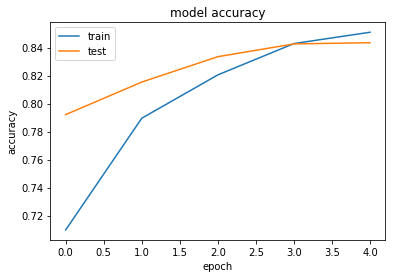

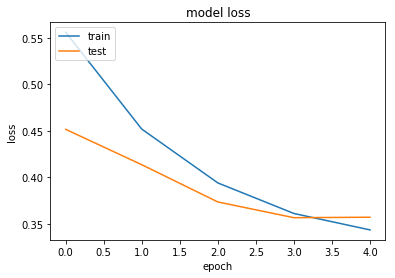

In [46]:
# Now we will plot the loss and accuracy differences for training and test set
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()